In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
import pandas as pd
import time
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization
from numpy import newaxis


Using TensorFlow backend.


In [2]:
df = pd.read_csv('./Datasets/goog.csv',header=None)
# dt = datetime.strptime(, "%y-%m-%d")
# dt
pd.Timestamp(df[0][1]).to_pydatetime().weekday()
df[0] = df[0].apply(lambda x: pd.Timestamp(x).to_pydatetime().weekday())

print(df.head())

   0           1           2           3         4
0  3  409.980706  393.490664  409.360714  20747600
1  3  417.310703  406.230704  416.470712  19263800
2  3  424.720741  415.780725  422.860734  20245500
3  3  428.750720  425.300728  428.620748   9716400
4  3  431.240735  422.440739  423.480726  22099300


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2881: UserWarning: Discarding nonzero nanoseconds in conversion
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.5/dist-packages/pandas/core/series.py:2294: UserWarning: Discarding nonzero nanoseconds in conversion
  mapped = lib.map_infer(values, f, convert=convert_dtype)


In [3]:
def load_data(filename, seq_len, normalise_window):
    
    sequence_length = seq_len + 1
    df = pd.read_csv(filename,header=None)
#     df = df.iloc[:,:-1]
#     print(df.head())
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    data = np.asarray(df)

    result = []
    for index in range(len(df) - sequence_length):
        result.append(data[index: index + sequence_length])
    # print(type(df[0]))
    # data = np.asarray(df)
    # data = np.reshape(df,(892,5))
    result = np.asarray(result)
    if normalise_window:
        res, denorm = normalise_windows(result)
    result = np.asarray(res)
    row = round(0.95 * result.shape[0])
    train = result[:int(row), :]
#     np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1, 1:]
    print(x_train.shape)
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1, 1:]
    print(x_test.shape)
    return [x_train, y_train, x_test, y_test,denorm]


In [4]:
def normalise_windows(window_data):
    normalised_data = []
#     for x in window_data:
#         t = []
#         for y in x:
#             y = y/1000
    denormalising_data =[]      
    for x in window_data:        
        p = x[0]
        t = []
        for y in x:
            temp = [((float(y[i]) / float(p[i]))-1) for i in range(len(y))]
            t.append(temp)
        normalised_data.append(t)
        denormalising_data.append(p)
    
    return normalised_data,denormalising_data


In [12]:
epochs  = 6
seq_len = 10
bsize = 1
print( '>Loading data...')
X_train, y_train, X_test, y_test, denormalising_data = load_data('./Datasets/goog.csv', seq_len, True)
denormalising_data = (np.asarray(denormalising_data))
denormalising_data = np.delete(denormalising_data,0,1)
print(denormalising_data[0])

>Loading data...
(2684, 10, 5)
(141, 10, 5)
[ 399.170697  409.980706  393.490664  409.360714]


In [8]:
from keras.models import model_from_json 
json_file = open('model.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
#load woeights into new model
loaded_model.load_weights("model.h5")
print("Loaded Model from disk")
loaded_model.compile(loss="mse", optimizer="adadelta", metrics=['accuracy'])
print("Evaluating model")
loaded_model.evaluate(X_test,y_test, batch_size=bsize)

Loaded Model from disk
Evaluating model
141/141 [==============================] - 1s      

[0.00036822033904005004, 0.2978723404255319]

In [13]:
def denormalise(input_data, denorm_window):
    final_values =[]
    print((input_data.shape))
    for x in range((input_data.shape[0])):
        temp = [ denorm_window[x][i]*(input_data[x][i] + 1) for i in range(input_data.shape[1])]
        final_values.append(temp)
    return np.asarray(final_values)

    

In [9]:
predicted = loaded_model.predict(X_test, batch_size=1)
print(predicted.shape)
print(y_test.shape)

(141, 4)
(141, 4)


In [15]:
ans = denormalise(y_test, denormalising_data)
print(ans)
pred = denormalise(predicted, denormalising_data)
print(pred)
#df1 = pd.DataFrame(pred)
#df1.to_csv('pred.csv')

(141, 4)
[[ 416.3458331   431.93488957  412.60534224  431.12008259]
 [ 431.45375139  439.80000831  428.58909278  440.10995198]
 [ 440.77519462  451.77794139  441.99811321  449.11130672]
 [ 452.00416483  453.14215227  451.71785569  453.41563621]
 [ 451.66159862  454.91532699  447.39404644  445.58840834]
 [ 429.28919843  429.05427792  409.28908645  411.11504849]
 [ 416.29677178  412.14566197  405.44590986  409.91917751]
 [ 415.3810954   418.19301157  411.26521483  417.35049578]
 [ 422.45154115  423.6543469   417.48217846  421.33649656]
 [ 421.20734746  422.24165639  408.5954134   408.94870746]
 [ 409.34505903  413.25188547  402.11156235  401.02395518]
 [ 401.62647004  402.49663602  394.88718554  399.25170517]
 [ 402.38455608  404.14432147  398.10911618  404.273056  ]
 [ 408.02712052  409.27460003  400.36210867  401.35753369]
 [ 405.1232513   405.82084552  399.59161746  404.49360381]
 [ 405.90280997  414.09761053  403.9659441   410.19868845]
 [ 409.05374516  413.06824687  408.30319534  41

                 0
0.043027  0.025686
0.055801  0.028833
0.056912  0.032187
0.061589  0.033169
0.050814  0.027072
0.011376  0.004535
0.029773  0.013450
0.015104  0.013636
0.013217  0.014887
0.010088  0.013227


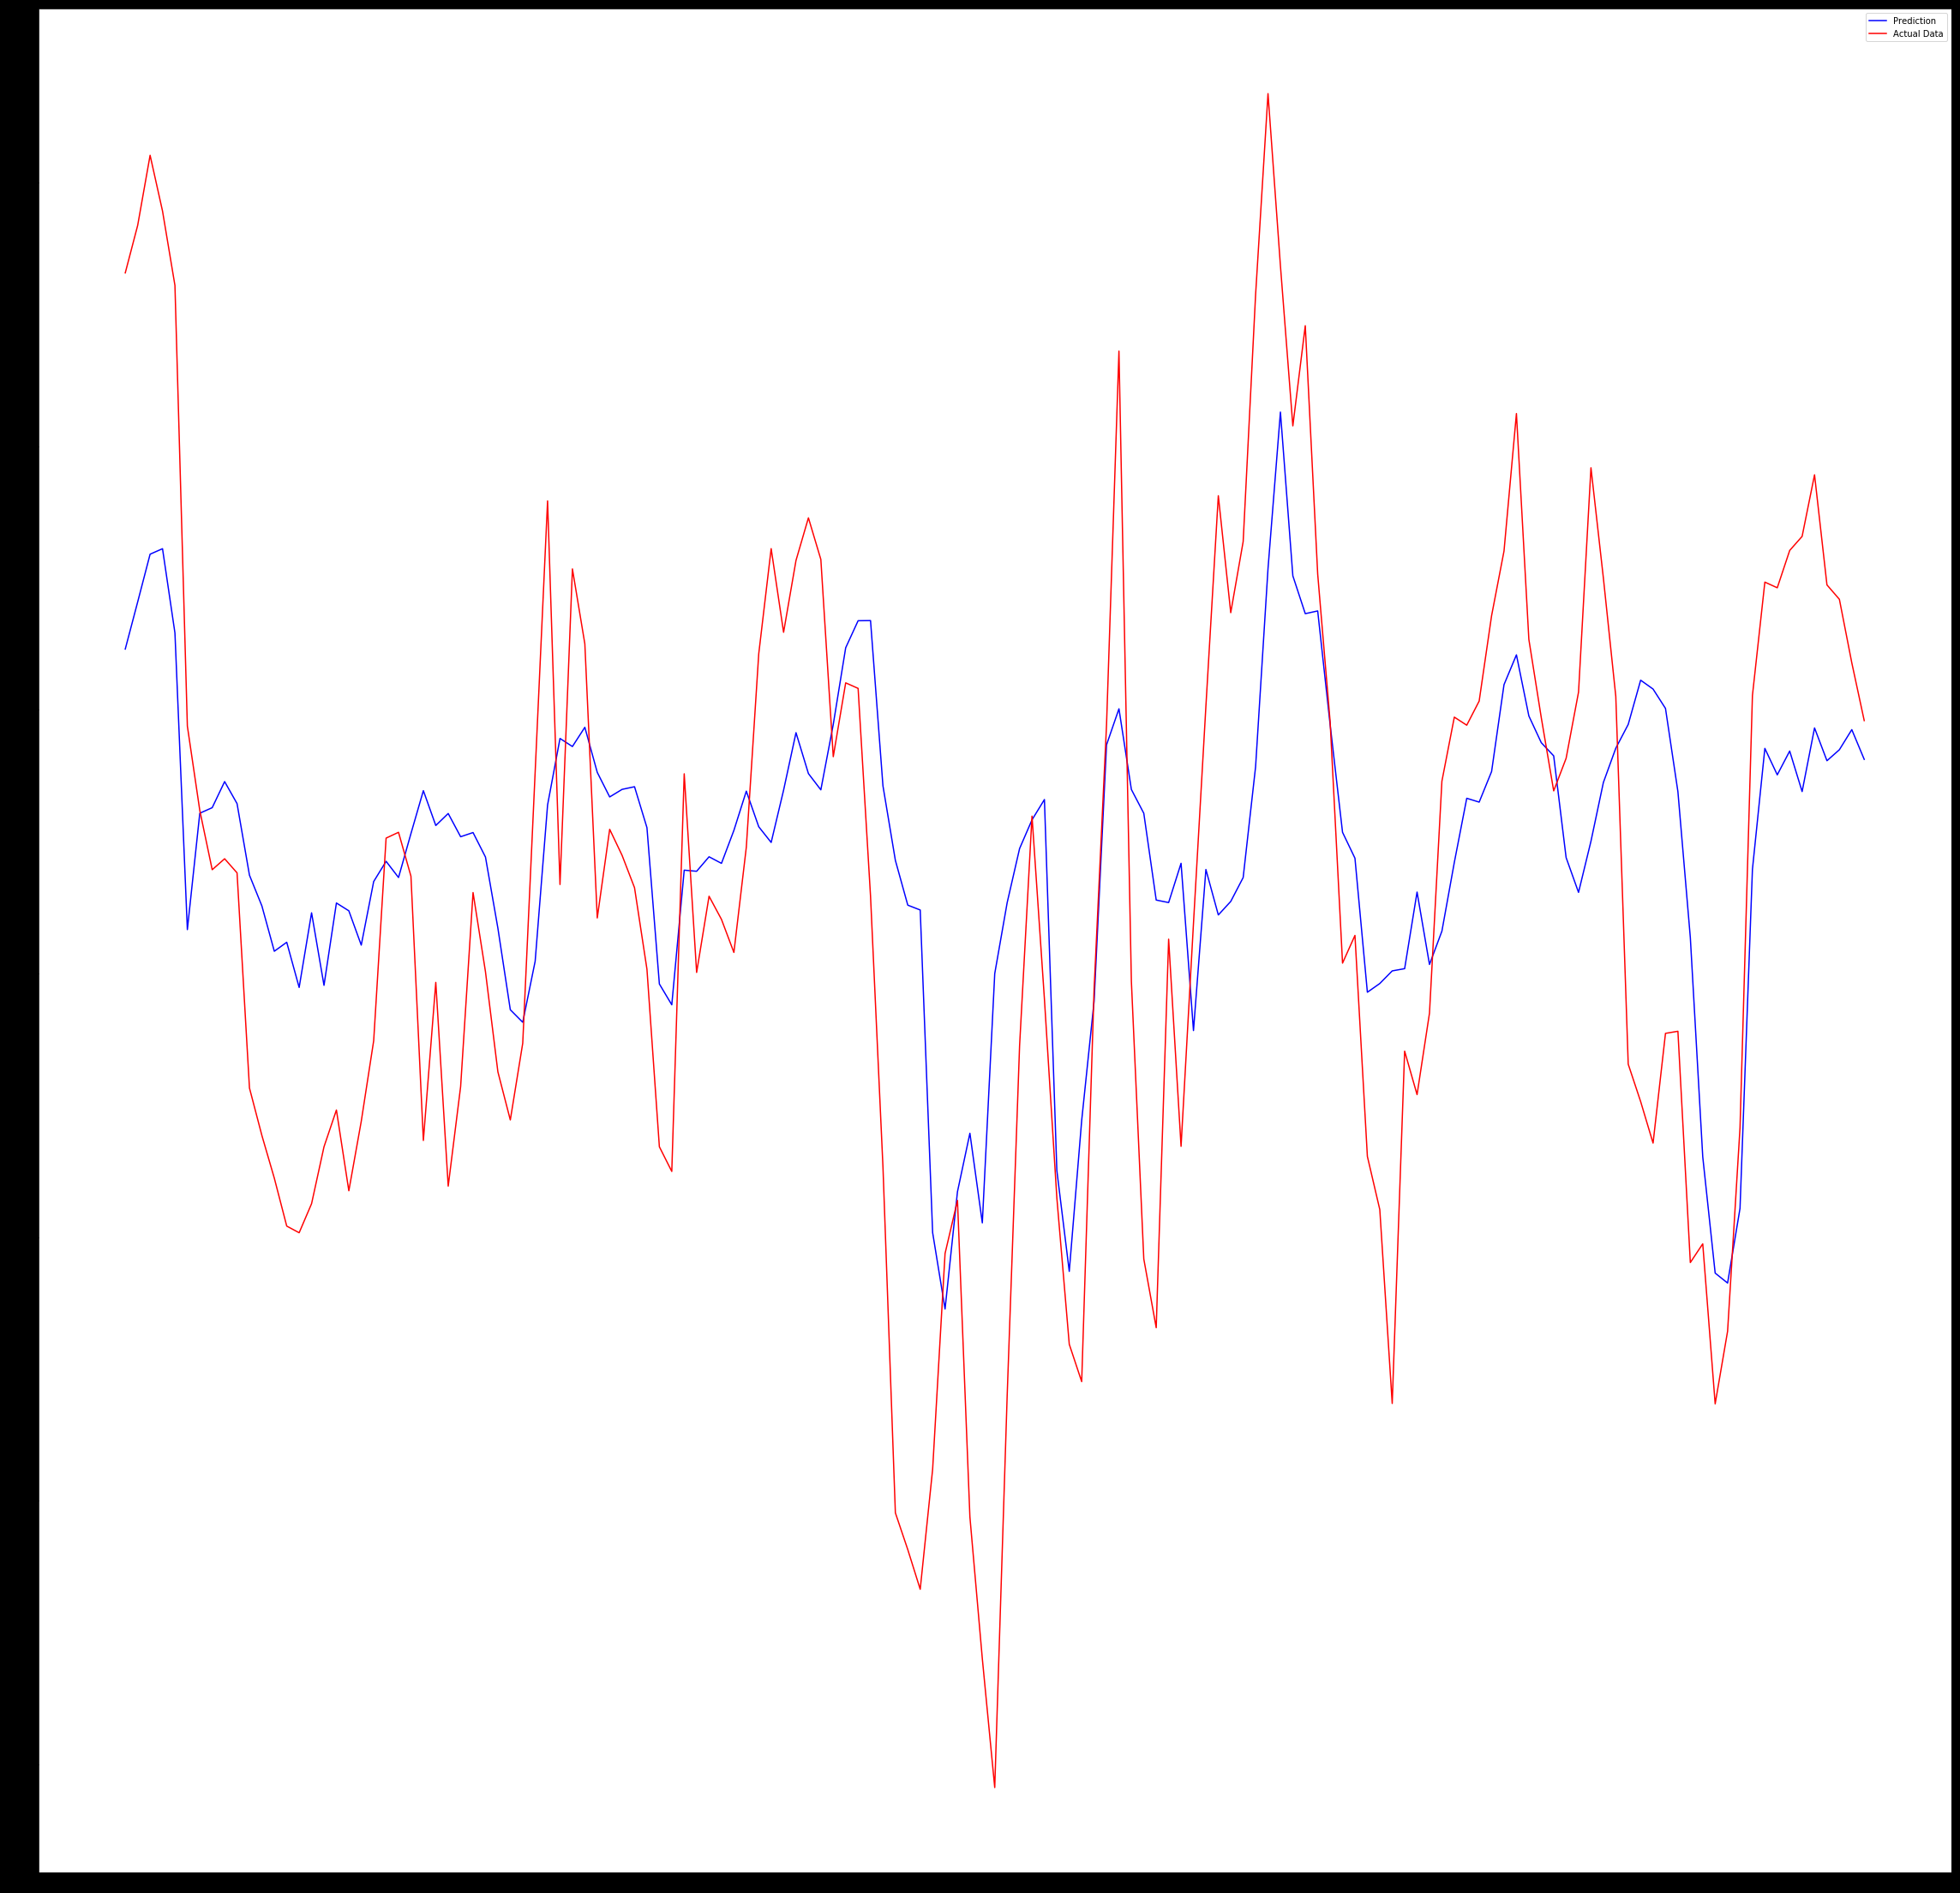

In [23]:
#open
openprice = predicted[0:170,0]
act_open = y_test[0:170,0]
print(pd.DataFrame(openprice[:10],act_open[:10]))

width = 40
height = 40
try:
    fig = plt.figure(figsize=(width, height), facecolor='black')
    plt.plot(close, color='blue', label='Prediction')
    plt.plot(act_close, color='red', label='Actual Data')
    plt.legend()
    plt.show()
except Exception as e:
    print(str(e))

                 0
0.053549  0.025296
0.053891  0.028582
0.063706  0.031657
0.056890  0.031630
0.054899  0.024784
0.006223  0.004832
0.009046  0.011028
0.006625  0.011568
0.009829  0.013822
0.011356  0.012582


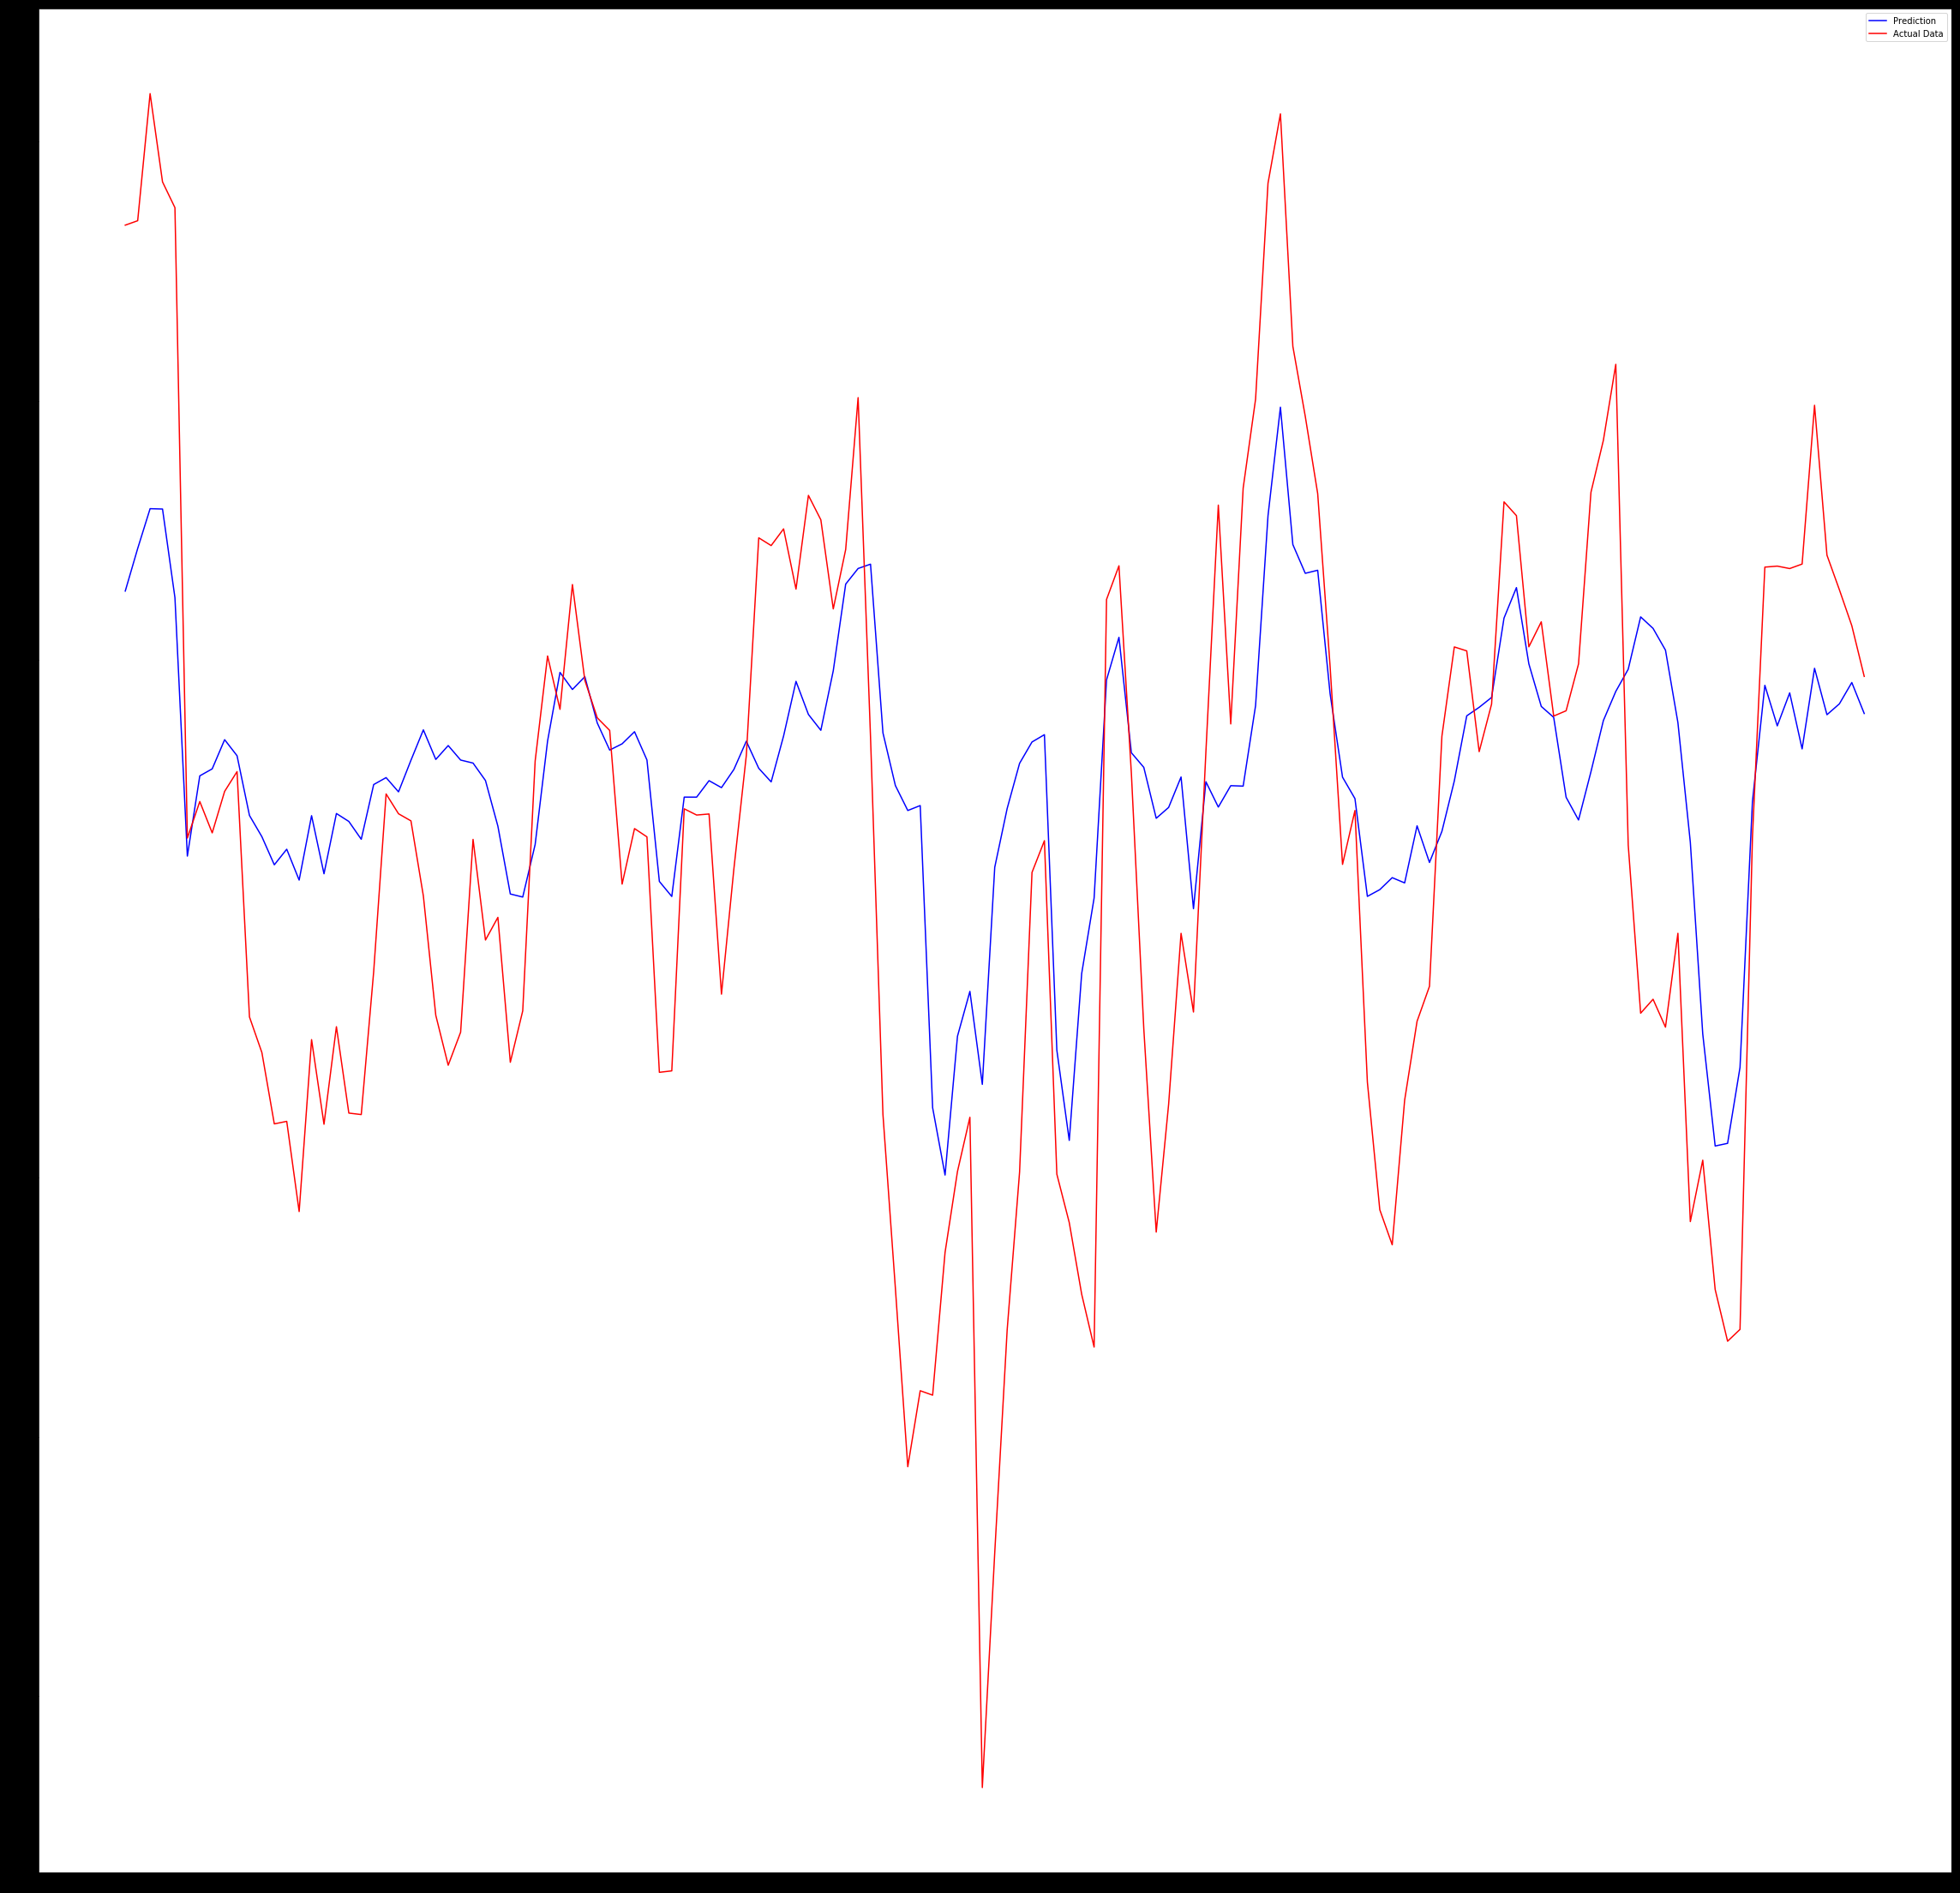

In [18]:
#high
high = predicted[0:170,1]
act_high = y_test[0:170,1]
print(pd.DataFrame(high[:10],act_high[:10]))
width = 40
height = 40
try:
    fig = plt.figure(figsize=(width, height), facecolor='black')
    plt.plot(close, color='blue', label='Prediction')
    plt.plot(act_close, color='red', label='Actual Data')
    plt.legend()
    plt.show()
except Exception as e:
    print(str(e))

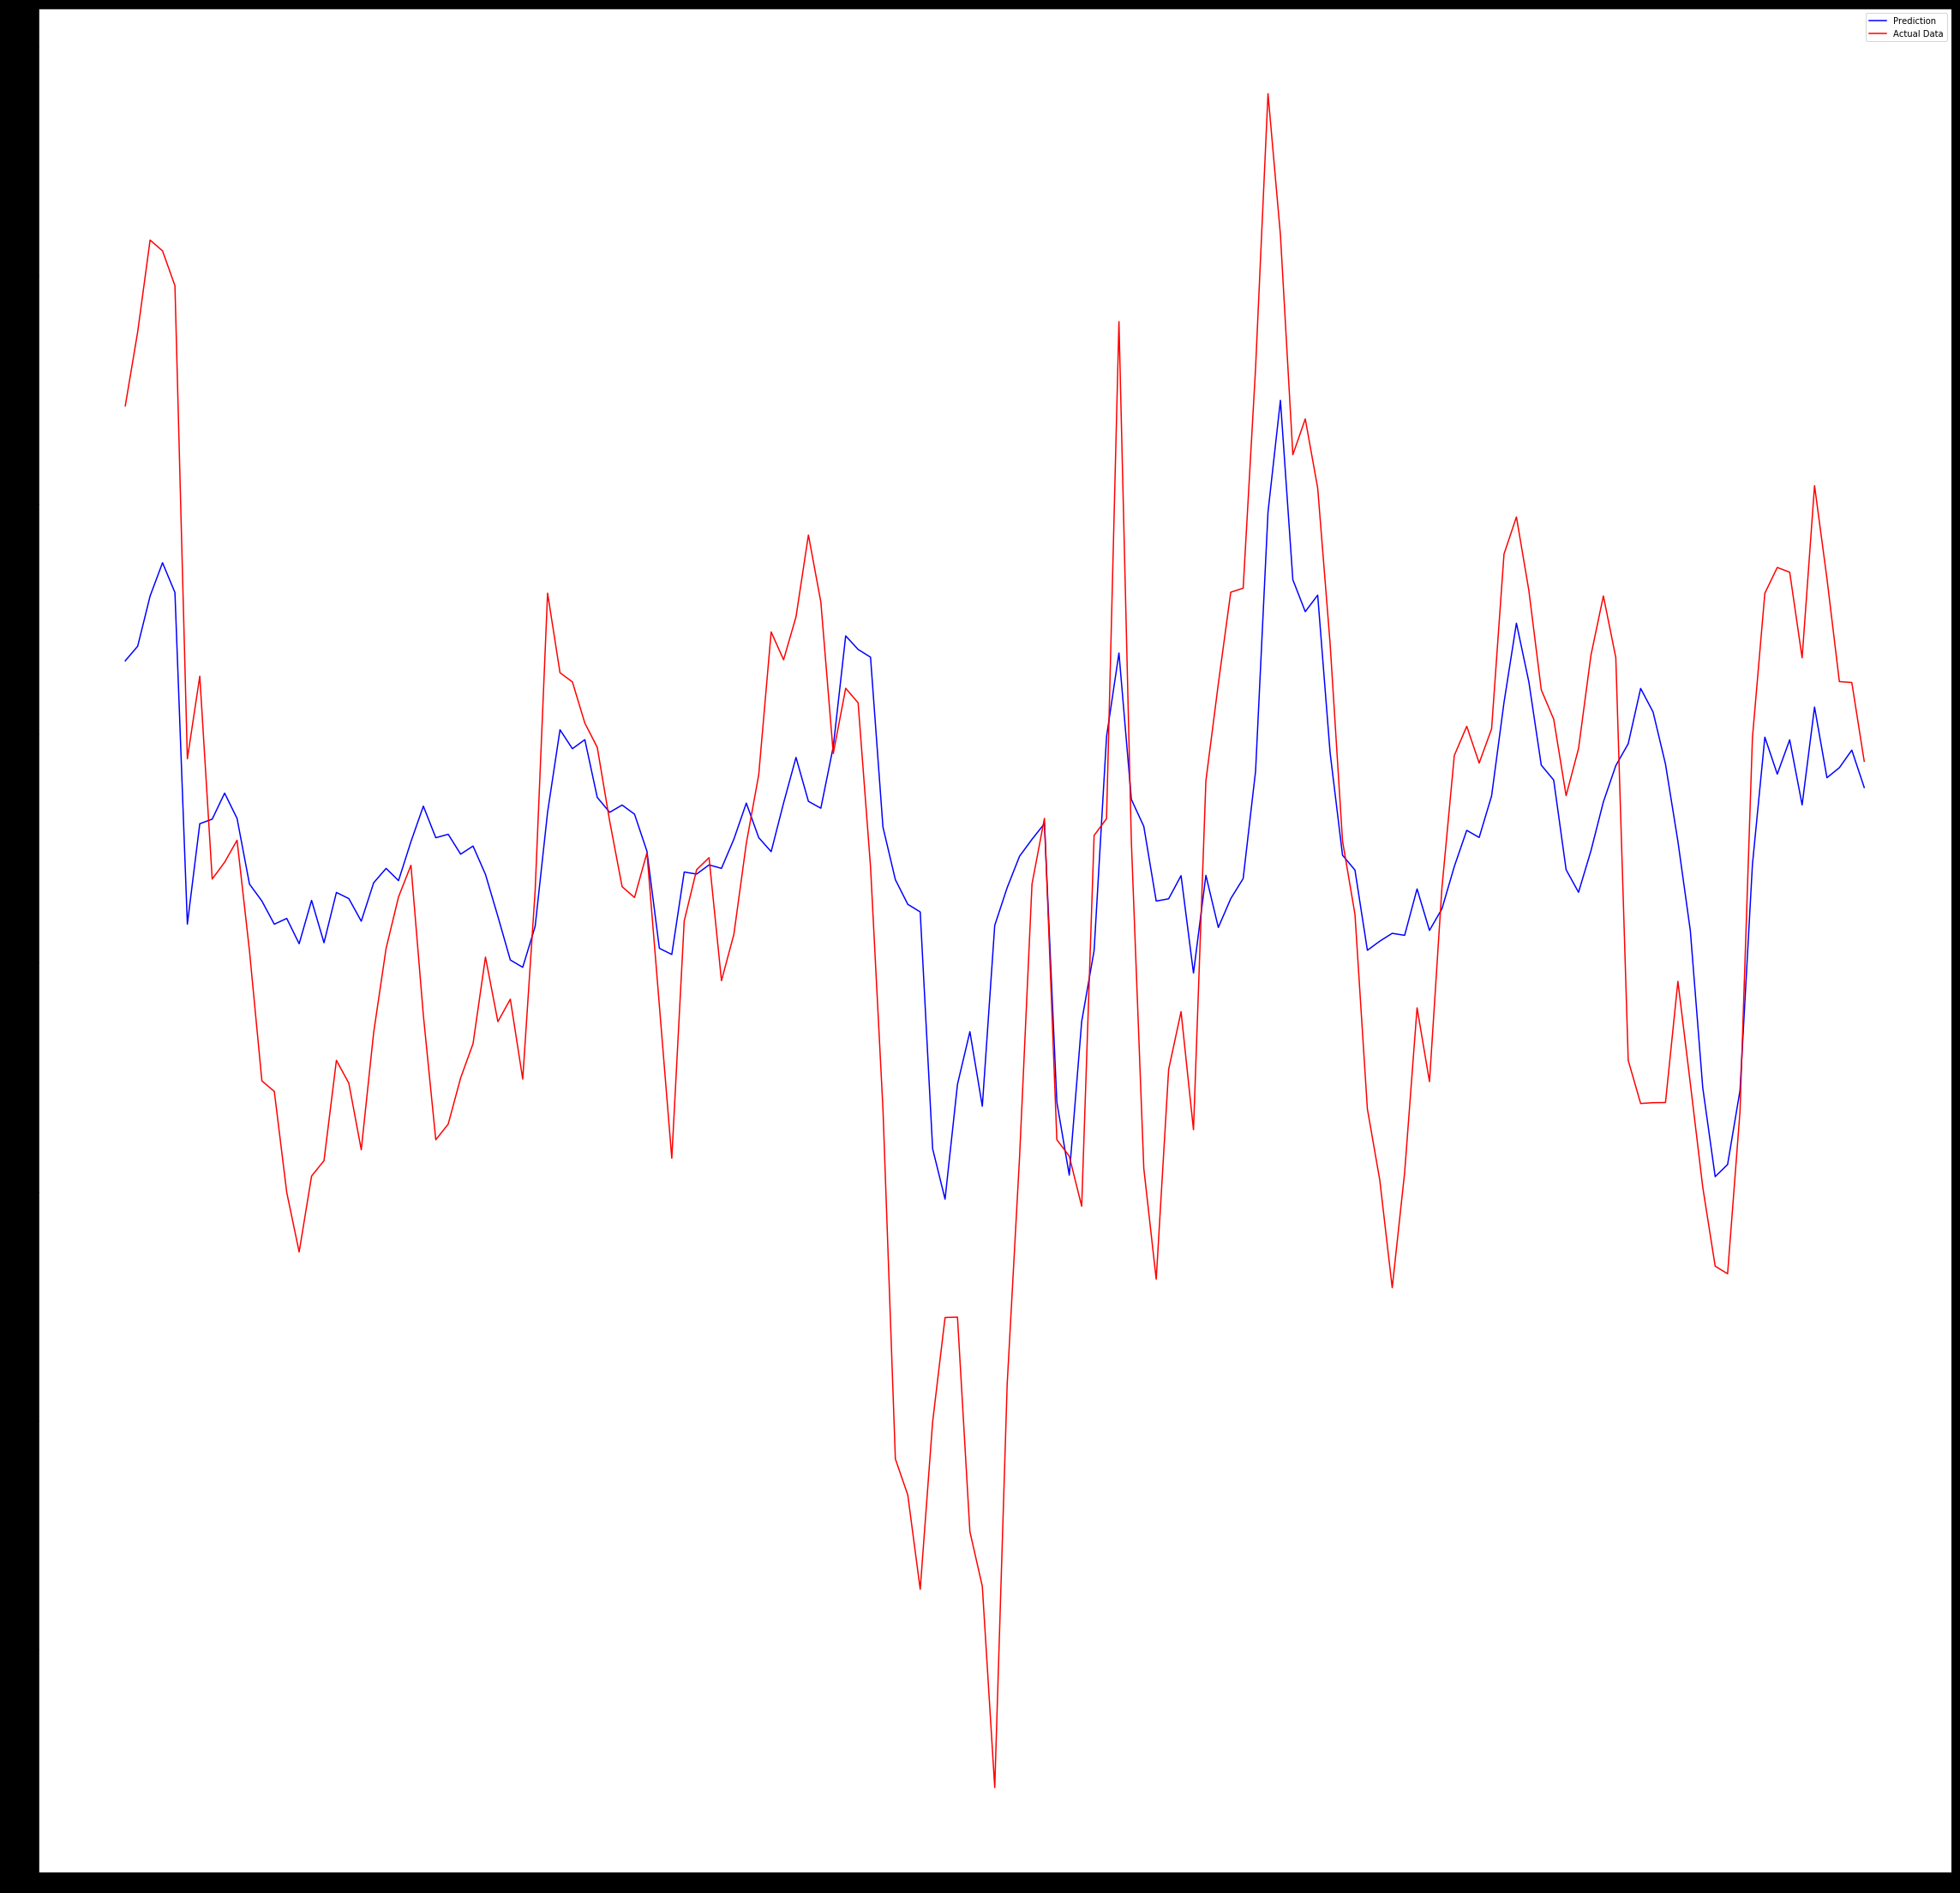

In [13]:
#low
low = predicted[0:170,2]
act_low = y_test[0:170,2]
print(pd.DataFrame(low[:10],act_low[:10]))

width = 40
height = 40
try:
    fig = plt.figure(figsize=(width, height), facecolor='black')
    plt.plot(close, color='blue', label='Prediction')
    plt.plot(act_close, color='red', label='Actual Data')
    plt.legend()
    plt.show()
except Exception as e:
    print(str(e))

                 0
0.053155  0.024613
0.056761  0.028190
0.062079  0.031813
0.057848  0.032228
0.052205  0.025834
0.018770  0.003326
0.012369  0.012159
0.007872  0.012579
0.008704  0.014558
0.007633  0.012888


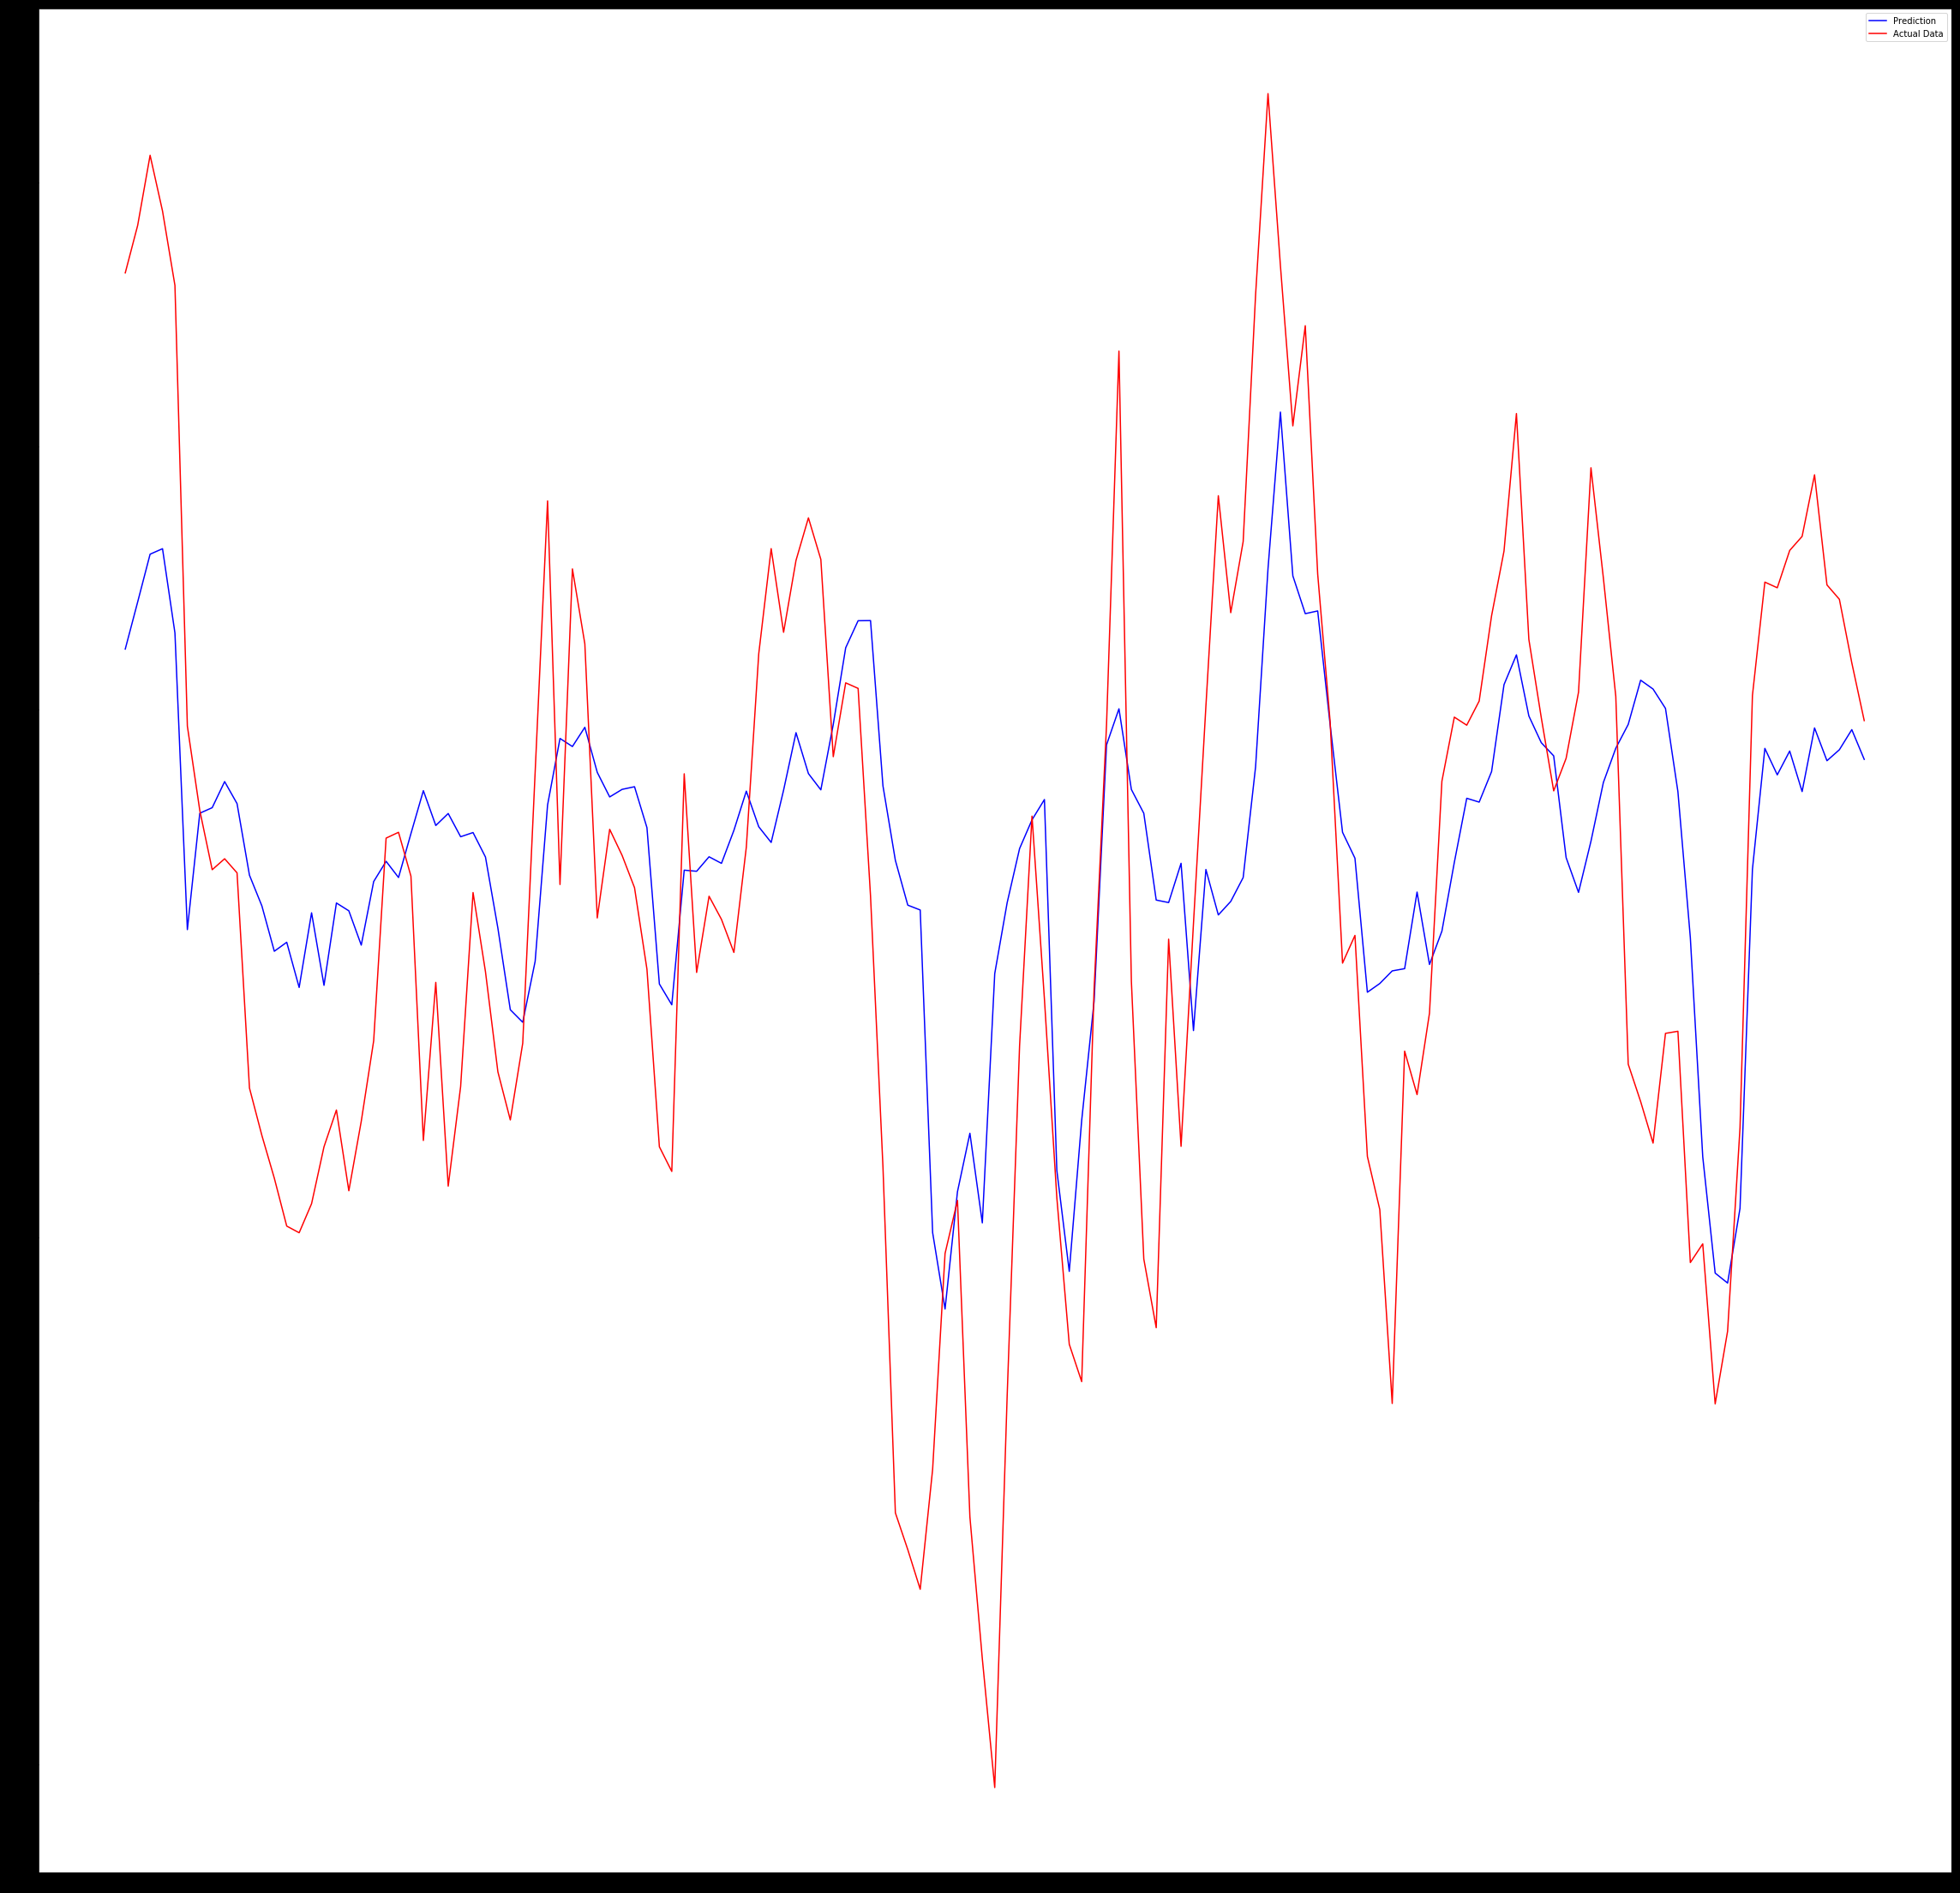

In [21]:
#close
close = predicted[0:170,3]
act_close = y_test[0:170,3]
print(pd.DataFrame(close[:10],act_close[:10]))

width = 40
height = 40
try:
    fig = plt.figure(figsize=(width, height), facecolor='black')
    plt.plot(close, color='blue', label='Prediction')
    plt.plot(act_close, color='red', label='Actual Data')
    plt.legend()
    plt.show()
except Exception as e:
    print(str(e))